# Robustness of main conclussions against alternate measures of cell size

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.legend import Legend

In [2]:
from scipy.stats import norm, kstest, probplot, mode, kurtosis, skew, mannwhitneyu, kruskal
from itertools import combinations

In [3]:
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm

In [4]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 15,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Load data

In [5]:
df = pd.read_table('place/fine_all.tsv', index_col = 0)
df.shape

(5380, 28)

In [6]:
df['sources'] = df['sources'].map(lambda x: 'bergeys' if x == 'bm1' or x == 'bm4' or x == 'bm5' else x)

Standardize shapes

In [7]:
def ref_shape(s):
    """Reformat "shape column".
    """
    if 'shaped' in s:
        s = s.split('-')[0]
    elif s == 'sphere/spheroid':
        return 'sphere'
    elif s == 'rods':
        return 'rod'
    elif '/' in s:
        s = '-'.join(s.split('/'))
    if s in ('ovoid', 'oval', 'ellipsoidal'):
        return 'ovoid'
    elif s == 'pear':
        return 'sphere'
    elif s in ('sphere', 'spherical'):
        return 'sphere'
    else:
        return s

In [8]:
df['shape'] = df['shape'].fillna('').map(ref_shape)

### Calculate other metrics of cell size

In [9]:
df['vsratio'] = df['volume_gmean'] / df['surface_gmean']

In [10]:
df['svratio'] = df['surface_gmean'] / df['volume_gmean']

**Linear measures**

[Equivalent spherical diameter](https://en.wikipedia.org/wiki/Equivalent_spherical_diameter).


The equivalent spherical diameter of a cell is the diameter of a sphere with equivalent volume (see Figure 1.3 from this [pdf](https://zenodo.org/records/6484683)).

**Derivation:** The volume of s sphere is $V_s = \frac{4}{3} \pi r^3$ and $d = 2r$. Then,

$$
V_s = \frac{4}{3} \pi \left(\frac{d}{2}\right)^3 = \frac{4}{3} \pi \frac{d^3}{8} = \frac{1}{6} \pi d^3
$$

$$
d_V = \sqrt[3]{\frac{6V}{\pi}}
$$

where $V$ is the volume of the cell, previously calculated using the formulae for a [capsule](https://en.wikipedia.org/wiki/Capsule_(geometry)).

In [11]:
df['equivalent_spherical'] = np.cbrt((6 * df['volume_gmean']) / np.pi)

In [12]:
df['unscaled_volume'] = np.cbrt(df['volume_gmean'])
df['unscaled_surface'] = np.sqrt(df['surface_gmean'])

In [13]:
df['equivalent_spherical'].describe()

count    5380.000000
mean        1.223847
std         4.415748
min         0.146965
25%         0.746717
50%         0.962619
75%         1.260236
max       235.785811
Name: equivalent_spherical, dtype: float64

In [13]:
metrics = ['length_gmean', 'width_gmean', 'volume_gmean', 'unscaled_volume', 'surface_gmean', 'unscaled_surface', 'svratio', 
           'vsratio', 'equivalent_spherical']
xlabels = ['Log (Length, $\\mu m$)', 'Log (Width, $\\mu m$)',
          'Log (Volume, $\\mu m^3$)', 'Log (Cube root of \nVolume, $\\mu m$)',
          'Log (Surface area, $\\mu m^2$)', 'Log (Square root of \nSurface area, $\\mu m$)',
          'Log (Surface-to-volume\nratio, $\\mu m^{-1}$)',
          'Log (Volume-to-surface\nratio, $\\mu m$)',
          'Log (Spherical\nequivalent diameter, $\\mu m$)']

Metric: length_gmean
	Mean: 0.29, 1.97
	Std: 0.31, 2.06
	Median: 0.28, 1.90
	Normality: 0.08, p-value: 1.5484042093803137e-27. p-value_cor: 1.5484042093803137e-27
	Kurtosis: 6.14
	Skewness: 1.09
Metric: width_gmean
	Mean: -0.22, 0.60
	Std: 0.25, 1.80
	Median: -0.22, 0.60
	Normality: 0.08, p-value: 4.160505418148137e-31. p-value_cor: 4.160505418148137e-31
	Kurtosis: 7.17
	Skewness: 1.01
Metric: volume_gmean
	Mean: -0.32, 0.48
	Std: 0.66, 4.53
	Median: -0.33, 0.47
	Normality: 0.06, p-value: 2.908422683250312e-19. p-value_cor: 2.908422683250312e-19
	Kurtosis: 10.38
	Skewness: 1.15
Metric: unscaled_volume
	Mean: -0.11, 0.78
	Std: 0.22, 1.65
	Median: -0.11, 0.78
	Normality: 0.06, p-value: 2.908422683250312e-19. p-value_cor: 2.908422683250312e-19
	Kurtosis: 10.38
	Skewness: 1.15
Metric: surface_gmean
	Mean: 0.57, 3.71
	Std: 0.45, 2.83
	Median: 0.55, 3.55
	Normality: 0.06, p-value: 2.6333367416075136e-18. p-value_cor: 2.6333367416075136e-18
	Kurtosis: 10.04
	Skewness: 1.09
Metric: unscaled_su

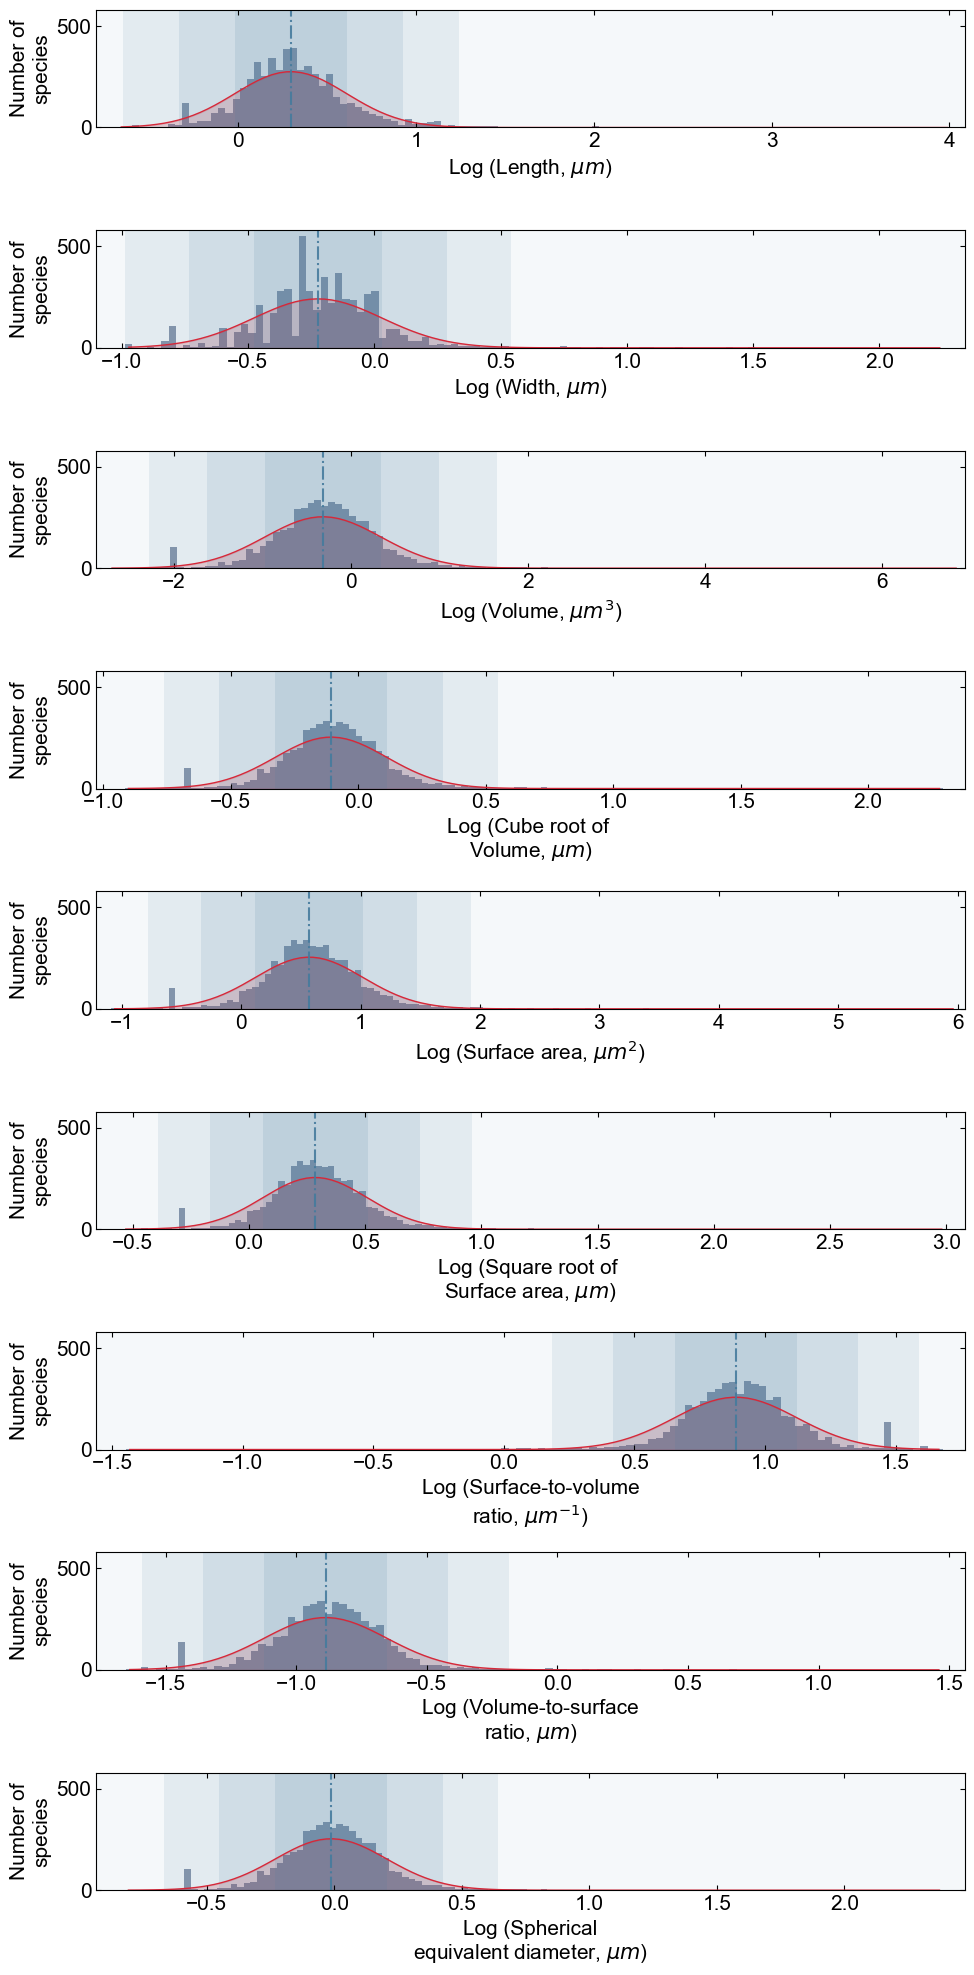

In [14]:
fig, ax = plt.subplots(len(metrics), 1, figsize = (10, 20), sharey = True, sharex = False)
for i, metric in enumerate(metrics):
    data = np.log10(df[metric])
    n = data.shape[0]
    parameters = norm.fit(data)
    # Basic statistics
    mu, std, med, kurt, skw = np.mean(data), np.std(data), np.median(data), kurtosis(data), skew(data)
    # Perform Kolmogorov-Smirnov test (goodness of fit)
    gft = kstest(data, 'norm', parameters)
    # Correct p-value due to multiple testing
    p_val_cor = multipletests(gft[1], alpha = 0.05, method = 'fdr_bh')[1]
    # Plot
    counts, bins = np.histogram(data, bins = 'auto')
    widths = bins[:-1] - bins[1:]
    ax[i].bar(bins[1:], counts, width = widths, color = '#8d99ae')
    # Add fitted normal distributio
    y_fitted = norm.pdf(bins[1:], parameters[0], parameters[1]) * len(data) * np.diff(bins[1:])[0]
    ax[i].plot(bins[1:], y_fitted, color = '#d62839', linewidth = 1,
                  linestyle = 'solid')
    ax[i].fill_between(bins[1:], y_fitted, 
                     color = '#d62839', linewidth = 1, alpha = 0.2)
    # Mean and std
    ax[i].axvline(x = mu, color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)
    for i_ in range(0, 4):
        low_r = mu + std * i_
        up_r = mu + std * (i_ + 1)
        low_l = mu - std * i_
        up_l = mu - std * (i_ + 1)
        if i_ == 3:
            up_r = np.max(data) + 0.5
            up_l = np.min(data) - 0.5
        ax[i].axvspan(low_r, up_r, alpha = 0.35 - i_ * 0.1, color = '#457b9d', lw = 0)
        ax[i].axvspan(low_l, up_l, alpha = 0.35 - i_ * 0.1, color = '#457b9d', lw = 0)
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_ylabel('Number of\nspecies')
    ax[i].set_xlim(np.min(data) - 0.1, np.max(data) + 0.1)
    print(f'Metric: {metric}')
    print(f'\tMean: {mu:.2f}, {(10 ** mu):.2f}')
    print(f'\tStd: {std:.2f}, {(10 ** std):.2f}')
    print(f'\tMedian: {med:.2f}, {(10 ** med):.2f}')
    print(f'\tNormality: {gft[0]:.2f}, p-value: {gft[1]}. p-value_cor: {p_val_cor[0]}')
    print(f'\tKurtosis: {kurt:.2f}')
    print(f'\tSkewness: {skw:.2f}')

plt.savefig('figures/metrics_cell_size.svg')
plt.show()

Median size of shapes --test only linear measures

In [63]:
sh_keys = [['coccus', 'sphere', 'ovoid'], ['rod'], ['filament'], ['helical', 'spiral', 'vibrio']]
sh_labels = ['Cocci', 'Rods', 'Filaments', 'Spirals']
sh_colors = ['#ef767a', '#456990', '#49beaa', '#9d4edd']

In [64]:
# sh_dats = [df.query('shape == @k')['vsratio'].apply(np.log10).values for k in sh_keys]

In [65]:
violin_args = dict(widths=0.8, showmedians=False, showextrema=False)
box_args = dict(whis=None, showcaps=False, widths=0.06, patch_artist=True,
                boxprops=dict(color='k', facecolor='k', alpha=0.8),
                whiskerprops=dict(color='k', linewidth=1, alpha=0.8),
                medianprops=dict(color='w', linewidth=2))

In [66]:
metrics = ['length_gmean', 'width_gmean', 'unscaled_volume', 'unscaled_surface',
           'vsratio', 'equivalent_spherical']
xlabels = ['Log (Length, $\\mu m$)', 'Log (Width, $\\mu m$)',
          'Log (Unscaled\nVolume, $\\mu m$)', 'Log (Unscaled\nSurface area, $\\mu m$)',
          'Log (Volume-to-surface\nratio, $\\mu m$)',
          'Log (Spherical\nequivalent diameter, $\\mu m$)']

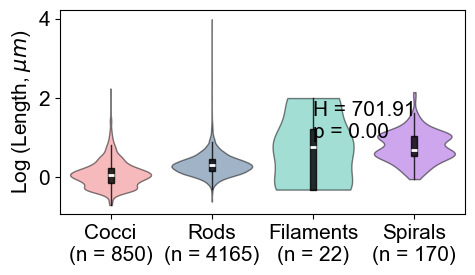

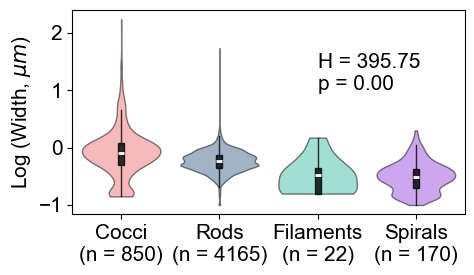

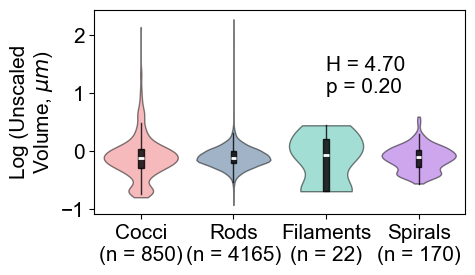

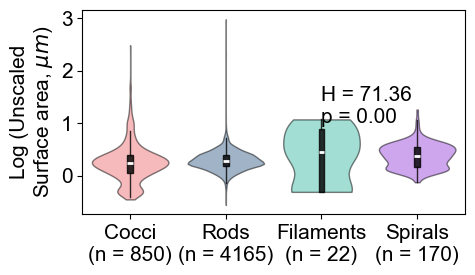

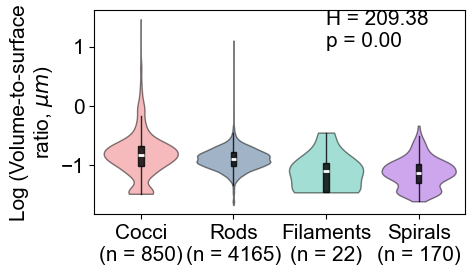

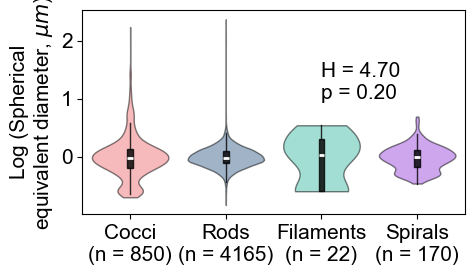

In [67]:
for num, metric in enumerate(metrics):
    sh_dats = [df.query('shape == @k')[metric].apply(np.log10).values for k in sh_keys]
    statistic, pvalue = kruskal(sh_dats[0], sh_dats[1], sh_dats[2], sh_dats[3])
    plt.figure(figsize=(5, 3))
    sh_ticks = []
    for i, (dat_, label, color) in enumerate(zip(sh_dats, sh_labels, sh_colors)):
        vlp = plt.violinplot(dat_, positions=[i], **violin_args)
        vlp['bodies'][0].set_facecolor(color)
        vlp['bodies'][0].set_edgecolor('k')
        vlp['bodies'][0].set_alpha(0.5)
        plt.boxplot(dat_, positions=[i], **box_args)
        sh_ticks.append(f'{label}\n(n = {dat_.shape[0]})')
    plt.xticks(np.arange(len(sh_dats)), sh_ticks)
    plt.ylabel(f'{xlabels[num]}')
    plt.text(2, 1, f'H = {statistic:.2f}\np = {pvalue:.2f}')
plt.show()

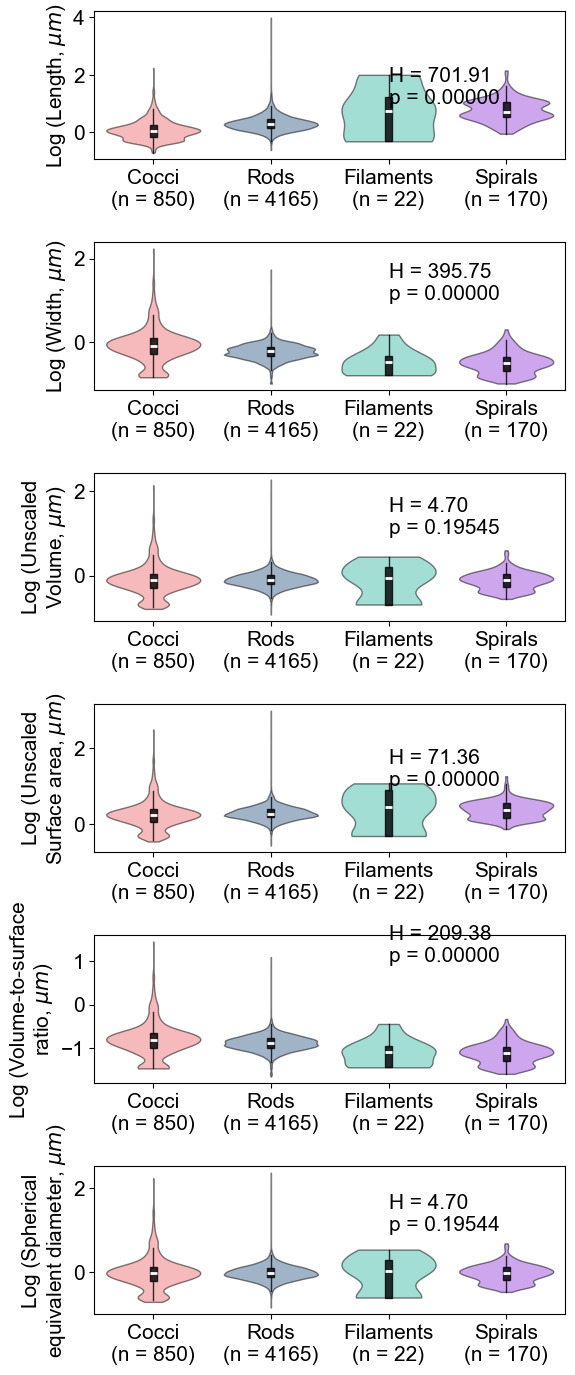

In [68]:
fig, ax = plt.subplots(len(metrics), 1, figsize = (6, 14), sharey = False, sharex = False)
for num, metric in enumerate(metrics):
    sh_dats = [df.query('shape == @k')[metric].apply(np.log10).values for k in sh_keys]
    statistic, pvalue = kruskal(sh_dats[0], sh_dats[1], sh_dats[2], sh_dats[3])
    sh_ticks = []
    for i, (dat_, label, color) in enumerate(zip(sh_dats, sh_labels, sh_colors)):
        vlp = ax[num].violinplot(dat_, positions=[i], **violin_args)
        vlp['bodies'][0].set_facecolor(color)
        vlp['bodies'][0].set_edgecolor('k')
        vlp['bodies'][0].set_alpha(0.5)
        ax[num].boxplot(dat_, positions=[i], **box_args)
        sh_ticks.append(f'{label}\n(n = {dat_.shape[0]})')
    ax[num].set_xticks(np.arange(len(sh_dats)), sh_ticks)
    ax[num].set_ylabel(f'{xlabels[num]}')
    ax[num].text(2, 1, f'H = {statistic:.2f}\np = {pvalue:.5f}')
plt.show()

Mann Whitney tests

In [74]:
for metric in metrics:
    print(metric)
    sh_dats = [df.query('shape == @k')[metric].apply(np.log10).values for k in sh_keys]
    for dat, sh in zip (sh_dats, sh_labels):
        print(f'\t{sh}: {np.median(dat):.2f}')

length_gmean
	Cocci: 0.06
	Rods: 0.30
	Filaments: 0.76
	Spirals: 0.70
width_gmean
	Cocci: -0.09
	Rods: -0.23
	Filaments: -0.48
	Spirals: -0.51
unscaled_volume
	Cocci: -0.12
	Rods: -0.11
	Filaments: -0.06
	Spirals: -0.10
unscaled_surface
	Cocci: 0.24
	Rods: 0.28
	Filaments: 0.45
	Spirals: 0.37
vsratio
	Cocci: -0.83
	Rods: -0.89
	Filaments: -1.09
	Spirals: -1.12
equivalent_spherical
	Cocci: -0.02
	Rods: -0.02
	Filaments: 0.03
	Spirals: -0.00


In [41]:
dfrs = []
for num, metric in enumerate(metrics):
    res = []
    for i, j in combinations(sh_keys, 2):
        shape_i = df.query('shape == @i')[metric].apply(np.log10).values
        shape_j = df.query('shape == @j')[metric].apply(np.log10).values
        # Test
        stat, pval = mannwhitneyu(shape_i, shape_j)
        res.append([f'{i}_{j}_{metric}', stat, pval])
    dfr = pd.DataFrame(res, columns = ['pair', 'MW_statistic', 'pvalue']).set_index('pair')
    # Correct p-values
    dfr['pvalue_corrected'] = multipletests(dfr['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]
    dfrs.append(dfr)

In [42]:
dfrs[0]

,MW_statistic,pvalue,pvalue_corrected
pair,,,
"['coccus', 'sphere', 'ovoid']_['rod']_length_gmean",928278.5,3.565049e-106,2.139029e-105
"['coccus', 'sphere', 'ovoid']_['filament']_length_gmean",6077.5,4.993653e-03,7.490479e-03
"['coccus', 'sphere', 'ovoid']_['helical', 'spiral', 'vibrio']_length_gmean",12536.0,4.364539e-65,1.309362e-64
['rod']_['filament']_length_gmean,34556.0,4.647378e-02,5.576854e-02
"['rod']_['helical', 'spiral', 'vibrio']_length_gmean",113799.5,5.440664e-51,1.088133e-50
"['filament']_['helical', 'spiral', 'vibrio']_length_gmean",1732.0,5.745979e-01,5.745979e-01


In [43]:
dfrs[1]

,MW_statistic,pvalue,pvalue_corrected
pair,,,
"['coccus', 'sphere', 'ovoid']_['rod']_width_gmean",2317780.5,5.017837e-46,3.010702e-45
"['coccus', 'sphere', 'ovoid']_['filament']_width_gmean",14783.0,3.144144e-06,4.716216e-06
"['coccus', 'sphere', 'ovoid']_['helical', 'spiral', 'vibrio']_width_gmean",118586.0,6.684850e-40,1.336970e-39
['rod']_['filament']_width_gmean,71178.5,7.208967e-06,8.650760e-06
"['rod']_['helical', 'spiral', 'vibrio']_width_gmean",570182.0,1.180510e-41,3.541529e-41
"['filament']_['helical', 'spiral', 'vibrio']_width_gmean",1931.0,8.047657e-01,8.047657e-01


In [46]:
dfrs[2]

,MW_statistic,pvalue,pvalue_corrected
pair,,,
"['coccus', 'sphere', 'ovoid']_['rod']_unscaled_volume",1693413.0,0.046136,0.276817
"['coccus', 'sphere', 'ovoid']_['filament']_unscaled_volume",8783.5,0.627258,0.752709
"['coccus', 'sphere', 'ovoid']_['helical', 'spiral', 'vibrio']_unscaled_volume",71444.0,0.818244,0.818244
['rod']_['filament']_unscaled_volume,41896.0,0.488354,0.752709
"['rod']_['helical', 'spiral', 'vibrio']_unscaled_volume",366002.5,0.453981,0.752709
"['filament']_['helical', 'spiral', 'vibrio']_unscaled_volume",1989.5,0.627157,0.752709


In [47]:
dfrs[3]

,MW_statistic,pvalue,pvalue_corrected
pair,,,
"['coccus', 'sphere', 'ovoid']_['rod']_unscaled_surface",1531787.0,5.802215e-10,1.740665e-09
"['coccus', 'sphere', 'ovoid']_['filament']_unscaled_surface",7517.0,1.159090e-01,1.656217e-01
"['coccus', 'sphere', 'ovoid']_['helical', 'spiral', 'vibrio']_unscaled_surface",50019.0,2.263508e-10,1.358105e-09
['rod']_['filament']_unscaled_surface,37427.0,1.380181e-01,1.656217e-01
"['rod']_['helical', 'spiral', 'vibrio']_unscaled_surface",266663.5,4.713906e-08,9.427811e-08
"['filament']_['helical', 'spiral', 'vibrio']_unscaled_surface",1950.0,7.455176e-01,7.455176e-01


In [49]:
dfrs[4]

,MW_statistic,pvalue,pvalue_corrected
pair,,,
"['coccus', 'sphere', 'ovoid']_['rod']_vsratio",2025274.5,3.296020e-11,6.592039e-11
"['coccus', 'sphere', 'ovoid']_['filament']_vsratio",13848.5,1.138571e-04,1.366286e-04
"['coccus', 'sphere', 'ovoid']_['helical', 'spiral', 'vibrio']_vsratio",110897.0,2.875286e-28,8.625858e-28
['rod']_['filament']_vsratio,69100.0,3.829714e-05,5.744571e-05
"['rod']_['helical', 'spiral', 'vibrio']_vsratio",553347.0,1.211498e-35,7.268990e-35
"['filament']_['helical', 'spiral', 'vibrio']_vsratio",1946.5,7.563934e-01,7.563934e-01


In [50]:
dfrs[5]

,MW_statistic,pvalue,pvalue_corrected
pair,,,
"['coccus', 'sphere', 'ovoid']_['rod']_equivalent_spherical",1693412.5,0.046135,0.276808
"['coccus', 'sphere', 'ovoid']_['filament']_equivalent_spherical",8783.5,0.627257,0.752709
"['coccus', 'sphere', 'ovoid']_['helical', 'spiral', 'vibrio']_equivalent_spherical",71444.0,0.818244,0.818244
['rod']_['filament']_equivalent_spherical,41896.0,0.488354,0.752709
"['rod']_['helical', 'spiral', 'vibrio']_equivalent_spherical",366003.5,0.453944,0.752709
"['filament']_['helical', 'spiral', 'vibrio']_equivalent_spherical",1989.5,0.627157,0.752709


# Arithmetic mean

In [15]:
df['vsratio'] = df['volume_amean'] / df['surface_amean']
df['svratio'] = df['surface_amean'] / df['volume_amean']

In [16]:
df['equivalent_spherical'] = np.cbrt((6 * df['volume_amean']) / np.pi)

In [17]:
df['unscaled_volume'] = np.cbrt(df['volume_amean'])
df['unscaled_surface'] = np.sqrt(df['surface_amean'])

In [18]:
metrics = ['length_amean', 'width_amean', 'unscaled_volume', 'unscaled_surface', 'svratio', 
           'vsratio', 'equivalent_spherical']
xlabels = ['Log (Length, $\\mu m$)', 'Log (Width, $\\mu m$)',
          'Log (Unscaled Volume, $\\mu m$)', 'Log (Unscaled Surface area, $\\mu m$)',
          'Log (Surface-to-volume ratio, $\\mu m^{-1}$)',
          'Log (Volume-to-surface ratio, $\\mu m$)',
          'Log (Spherical equivalent diameter)']

Metric: length_gmean
	Mean: 0.29, 1.97
	Std: 0.31, 2.06
	Median: 0.28, 1.90
	Normality: 0.08, p-value: 1.5484042093803137e-27. p-value_cor: 1.5484042093803137e-27
	Kurtosis: 6.14
	Skewness: 1.09
Metric: width_gmean
	Mean: -0.22, 0.60
	Std: 0.25, 1.80
	Median: -0.22, 0.60
	Normality: 0.08, p-value: 4.160505418148137e-31. p-value_cor: 4.160505418148137e-31
	Kurtosis: 7.17
	Skewness: 1.01
Metric: volume_gmean
	Mean: -0.32, 0.48
	Std: 0.66, 4.53
	Median: -0.33, 0.47
	Normality: 0.06, p-value: 2.908422683250312e-19. p-value_cor: 2.908422683250312e-19
	Kurtosis: 10.38
	Skewness: 1.15
Metric: unscaled_volume
	Mean: -0.11, 0.78
	Std: 0.22, 1.65
	Median: -0.11, 0.78
	Normality: 0.06, p-value: 2.908422683250312e-19. p-value_cor: 2.908422683250312e-19
	Kurtosis: 10.38
	Skewness: 1.15
Metric: surface_gmean
	Mean: 0.57, 3.71
	Std: 0.45, 2.83
	Median: 0.55, 3.55
	Normality: 0.06, p-value: 2.6333367416075136e-18. p-value_cor: 2.6333367416075136e-18
	Kurtosis: 10.04
	Skewness: 1.09
Metric: unscaled_su

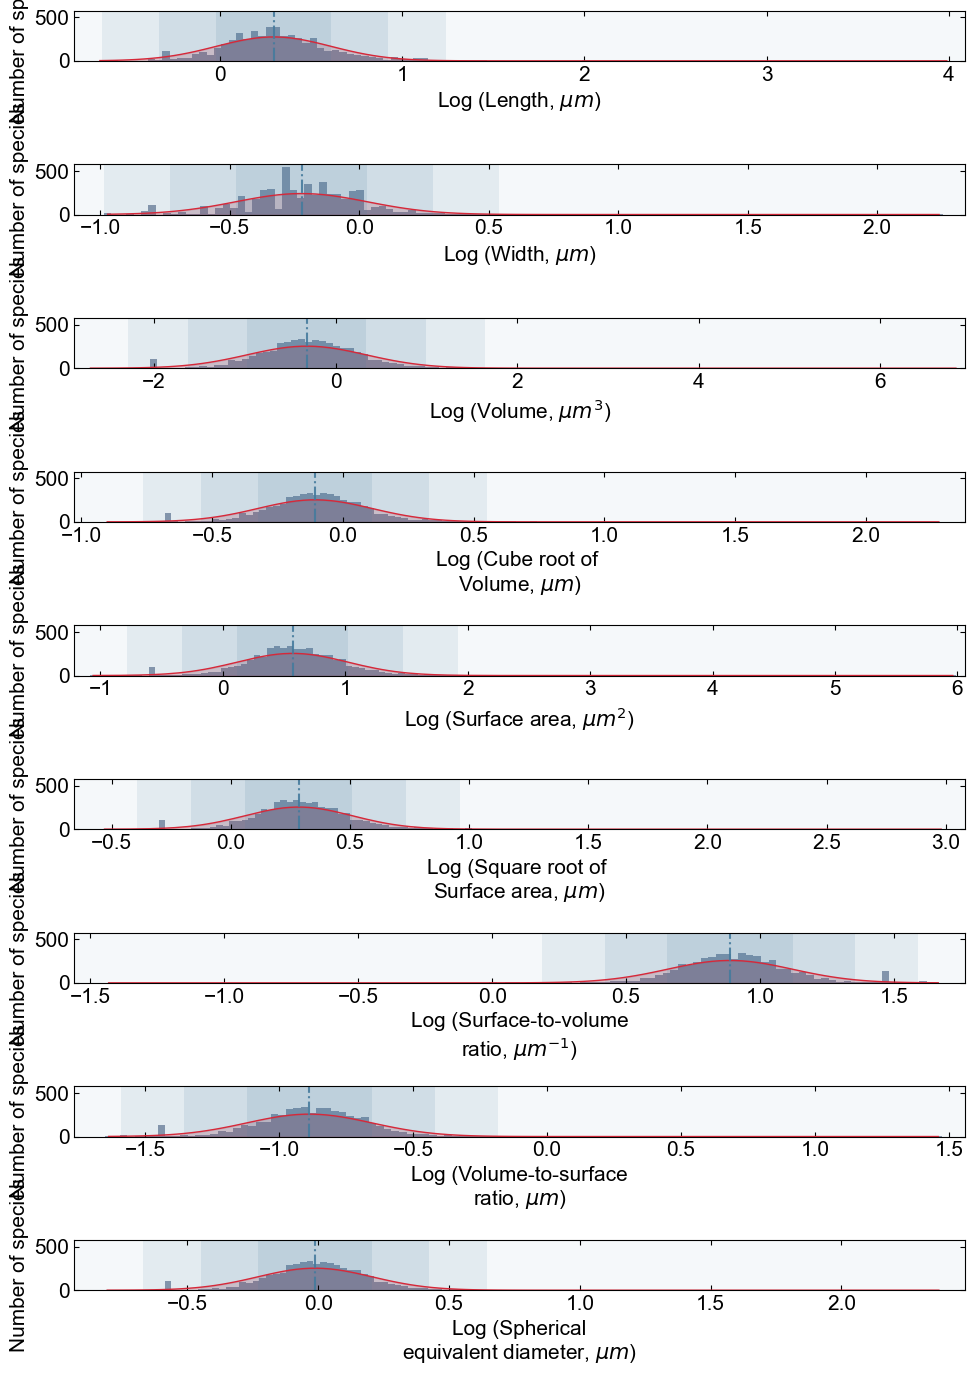

In [16]:
fig, ax = plt.subplots(len(metrics), 1, figsize = (10, 14), sharey = True, sharex = False)
for i, metric in enumerate(metrics):
    data = np.log10(df[metric])
    n = data.shape[0]
    parameters = norm.fit(data)
    # Basic statistics
    mu, std, med, kurt, skw = np.mean(data), np.std(data), np.median(data), kurtosis(data), skew(data)
    # Perform Kolmogorov-Smirnov test (goodness of fit)
    gft = kstest(data, 'norm', parameters)
    # Correct p-value due to multiple testing
    p_val_cor = multipletests(gft[1], alpha = 0.05, method = 'fdr_bh')[1]
    # Plot
    counts, bins = np.histogram(data, bins = 'auto')
    widths = bins[:-1] - bins[1:]
    ax[i].bar(bins[1:], counts, width = widths, color = '#8d99ae')
    # Add fitted normal distributio
    y_fitted = norm.pdf(bins[1:], parameters[0], parameters[1]) * len(data) * np.diff(bins[1:])[0]
    ax[i].plot(bins[1:], y_fitted, color = '#d62839', linewidth = 1,
                  linestyle = 'solid')
    ax[i].fill_between(bins[1:], y_fitted, 
                     color = '#d62839', linewidth = 1, alpha = 0.2)
    # Mean and std
    ax[i].axvline(x = mu, color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)
    for i_ in range(0, 4):
        low_r = mu + std * i_
        up_r = mu + std * (i_ + 1)
        low_l = mu - std * i_
        up_l = mu - std * (i_ + 1)
        if i_ == 3:
            up_r = np.max(data) + 0.5
            up_l = np.min(data) - 0.5
        ax[i].axvspan(low_r, up_r, alpha = 0.35 - i_ * 0.1, color = '#457b9d', lw = 0)
        ax[i].axvspan(low_l, up_l, alpha = 0.35 - i_ * 0.1, color = '#457b9d', lw = 0)
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_ylabel('Number of species')
    ax[i].set_xlim(np.min(data) - 0.1, np.max(data) + 0.1)
    print(f'Metric: {metric}')
    print(f'\tMean: {mu:.2f}, {(10 ** mu):.2f}')
    print(f'\tStd: {std:.2f}, {(10 ** std):.2f}')
    print(f'\tMedian: {med:.2f}, {(10 ** med):.2f}')
    print(f'\tNormality: {gft[0]:.2f}, p-value: {gft[1]}. p-value_cor: {p_val_cor[0]}')
    print(f'\tKurtosis: {kurt:.2f}')
    print(f'\tSkewness: {skw:.2f}')
    
plt.show()

### Another metric

Reduced volume from the 'Giant vesicle book'

$$
v = \frac{6 \sqrt{\pi} V}{S^{3/2}}
$$

which is unitless and dimensionless measure. $V$ = volume and $S$ = surface.

In [79]:
df['reduced_volume'] = (6 * np.sqrt(np.pi) * df['volume_gmean']) / (df['surface_gmean'] ** (3/2))
df['log_reduced_volume'] = np.log10(df['reduced_volume'])

In [80]:
metrics = ['log_reduced_volume']
xlabels = ['Log (reduced volume)']

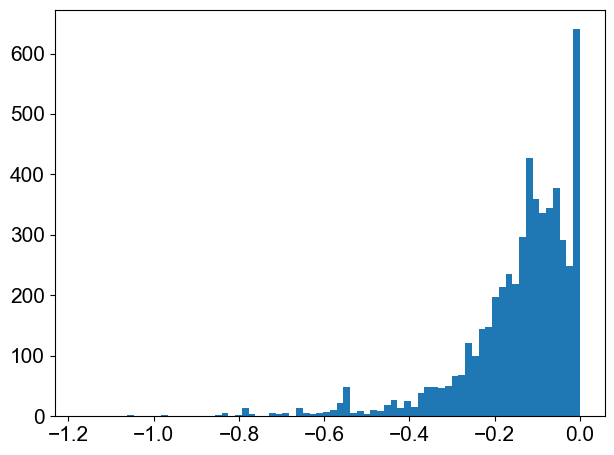

In [85]:
plt.figure()
plt.hist(df['log_reduced_volume'], bins = 'auto')
plt.show()